# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.663272,False,1.300946
1,-0.971923,True,1.930220
2,-2.058550,False,-5.887663
3,-1.975342,False,-5.227590
4,0.002485,True,3.523150
...,...,...,...
995,-2.072616,False,-4.130594
996,-1.150093,False,-3.387742
997,-1.953267,True,-1.515564
998,0.656589,True,8.188685


<AxesSubplot:xlabel='v0'>

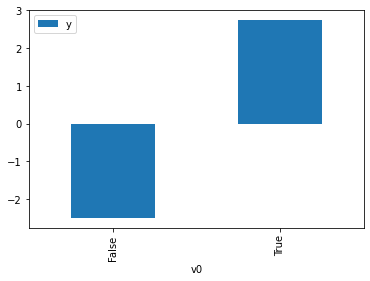

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

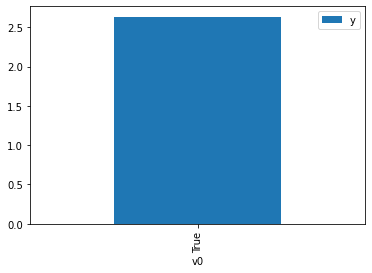

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.148133,False,-0.142022,0.505068,1.979931
1,0.044572,False,1.017675,0.512014,1.953073
2,-0.057087,False,-0.379753,0.518827,1.927425
3,-1.238349,False,-1.586322,0.596845,1.675477
4,1.568434,False,3.275001,0.410750,2.434571
...,...,...,...,...,...
995,-1.167399,False,-4.252861,0.592255,1.688461
996,-0.272404,False,-0.594548,0.533232,1.875356
997,-1.110752,False,-2.751552,0.588579,1.699006
998,-1.566714,False,-3.350136,0.617855,1.618503


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.116181,True,-0.342258,0.347986,2.873677
1,0.399631,True,7.681840,0.511802,1.953881
2,-1.473042,True,1.249242,0.388097,2.576672
3,-0.849625,True,3.319554,0.428488,2.333786
4,0.551159,True,4.599578,0.521956,1.915871
...,...,...,...,...,...
995,-1.658473,True,-0.262118,0.376348,2.657113
996,-0.810453,True,3.243911,0.431064,2.319839
997,-0.092907,True,3.178890,0.478774,2.088669
998,-1.243633,True,1.056300,0.402814,2.482536


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6786.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        15:42:34   Log-Likelihood:                         -1426.2
No. Observations:                1000   AIC:                                      2856.
Df Residuals:                     998   BIC:                                      2866.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5216      0.025     99.409      0.000       2.472       2.571
x2             5.0134      0.053     94.363      0.000       4.909       5.118
==============================================================================
Omnibus:                        3.459   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                3.037
Skew:                          -0.056   Prob(JB):                        0.219
Kurtosis:                       2.754   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""